# Quantum Singular Value Transformation (QSVT) 

In this work we will explore the Quantum Singular Value Transformation (QSVT), a framework that unifies many prominent quantum algorithms. 

## Quantum Signal Processing

For pedagogical purposes, we would like to start the discussion of QSVT with Quantum Singular Processing (QSP). Following Martyn et al. [1], we will implement two 
quantum circuits. The first one computes the Chebyshev polynomial of the first kind of a real number $a$, while the second one we can realize the BB1 pulse sequence. 


In [1]:
# import libraries 
import numpy as np
import scipy 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.quantum_info import Pauli, Operator
from scipy.special import chebyt
from matplotlib import pyplot as plt
import pyqsp
from functools import reduce
from pyqsp import angle_sequence
from IPython.utils import io # this is for suppressing output from pyqsp

# plotting parameters
plt.rcParams['figure.figsize'] = [5, 5]

In [2]:
# signal rotation operator 
def W(a): 
    '''
    Return the signal rotation operator
    Arguments: 
        a: the parameter of the signal rotation operator, i.e theta = -2acos(a)
    Returns: 
        W: numpy array with the signal rotation operator
    '''
    return np.array([[a, 1j*np.sqrt(1-a**2)], [1j*np.sqrt(1-a**2), a]])

# Quantum signal processing circuit
def create_QSP_circuit(a,phi):
    '''
    Create a QSP circuit with parameters a and phi. 
    Arguments: 
        a  : rotation angle of the signal rotation operator.
        phi: numpy array with the rotation phases
    Returns: 
        qc :  a quantum circuit which implements the QSP 
    '''
    q = QuantumRegister(1)
    qc = QuantumCircuit(q)
    # add the phi0 signal-processing rotation 
    qc.rz(phi[0],q)
    # add the QSP rotations
    for i in range(1,phi.size):
        qc.unitary(W(a),q, label='W')
        qc.rz(-2*phi[i],q)
    return qc


### Chebyshev polynomial with QSP 

Here, we calculate the Chebyshev polynomial of the first kind of order $n$ of a real number $a$. We should note that, in a real Quantum Computer, we don't have 
direct access to the calculated value, since it is encoded as a probability amplitude. So, in a sense, we "cheat" a little bit here. 

Text(0, 0.5, '$T_{5}(x)$')

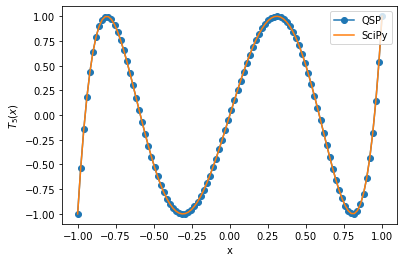

In [3]:
# create the backend, it will be used to run all the circuits
backend = Aer.get_backend('statevector_simulator')

# parameters of the QSP
N = 5 ; # order of the Chebyshev polynomial
phi = np.zeros(N+1) ; # rotation phases

x = np.linspace(-1,1,100)
chebyt_qsp = np.zeros(x.size)
chebyt_builtin = np.zeros(x.size)

for i in range(x.size):
    qc = create_QSP_circuit(x[i],phi)
    job = backend.run(qc)
    result = job.result()
    output_state = result.get_statevector(qc)
    calculated_chebyt = output_state.data[0]
    chebyt_qsp[i] = np.real(calculated_chebyt)
    chebyt_builtin[i] = chebyt(N)(x[i])

# plot the results
plt.plot(x,chebyt_qsp, label='QSP', marker = 'o')
plt.plot(x,chebyt_builtin, label='SciPy')
plt.legend()
plt.xlabel('x')
plt.ylabel(r'$T_{%d}(x)$'%N)

### BB1 Pulse

We reproduce the Figure 1 of [1], which shows the BB1 pulse sequence.

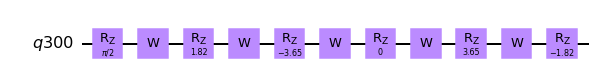

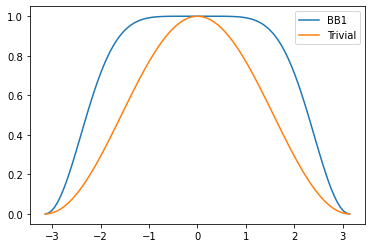

In [4]:
eta = 1/2 * np.arccos(-1/4)
phi = np.array([np.pi/2,-eta, 2*eta,0,-2*eta,eta])
theta = np.linspace(-np.pi,np.pi,100)
p = np.zeros(theta.size)
s = np.zeros(theta.size)

for i in range(theta.size):
    qc = create_QSP_circuit(np.cos(-theta[i]/2),phi)
    job = backend.run(qc)
    result = job.result()
    output_state = result.get_statevector(qc)
    p[i]= np.abs(output_state.data[0])**2
    qc = create_QSP_circuit(np.cos(-theta[i]/2),np.array([0,0]))
    job = backend.run(qc)
    result = job.result()
    output_state = result.get_statevector(qc)
    s[i]= np.abs(output_state.data[0])**2

# plot the probability with respect to theta
#p_theoretical = 1/8 * np.cos(theta/2)**2 *[3*np.cos(theta/2)**8 - 15*np.cos(theta/2)**6 + 35*np.cos(theta/2)**4 - 45*np.cos(theta/2)**2 + 30]
plt.plot(theta,p, label = 'BB1')
plt.plot(theta,s, label = 'Trivial')
plt.legend()

# plot the quantum signal processing circuit, for theta = -pi 
qc = create_QSP_circuit(np.cos(-theta[0]/2),phi)
qc.draw(output = 'mpl')


## Search by QSVT

We will now use the QSVT to implement a search algorithm. Some remarks: 
1. The unitary matrix we wish to block encode is the $H^{\otimes n}$, where $H$ is the Hadamard gate. In the paper they block encode the identity matrix, assuming that the initial state is the uniform superposition. Here, we assume that the initial state is the zero state and we block encode the $H^{\otimes n}$ matrix. 
2. In order to apply the projector controlled phase shift, we used the fact that $e^{i(2P-1)x} = cos(x) + (2P-I)sin(x)$, where $P$ is the projector. This is relation can be easily proved by using the euler formula for the exponential function, expanding the sine and cosine functions as a power series and using the fact that $P^2 = P$.
3. The phases for the sign approximation are calculated using the python library pyqsp. 
4. In general, in a search algorithm, we assume that we have an oracle that marks the solution. Using that oracle, we can implement the projector controlled phase shift to the marked state, even if we don't know the marked state. In our case, we just chose a random marked state and defined the projector that projects onto that state. This is not what we would do in a real search algorithm, but we assumed it here for simplicity. 


Possible improvements:
1) Use an oracle that marks a particular state instead of choosing a random state. It is not crucial, but it would be more realistic.

In [101]:
from qiskit.quantum_info import partial_trace
from qiskit.circuit.library import GlobalPhaseGate

def p_controlled_phase_shift(P, phi):
    '''
    Return the projector-controlled phase shift operator. 
    Arguments:
        P  : the projector
        phi: the rotation angle
    Returns:
        U  : numpy array with the projector-controlled phase shift operator
    Note: This is for educational purposes only. For a more efficient implementation, see the function projector_controlled_phase_shift below.
    '''
    N = len(P)
    return np.eye(N)*np.cos(phi)+1j*(2*P-np.eye(N))*np.sin(phi)

def projector_controlled_phase_shift(P, phi, num_qubits, kind): 
    '''
    Return a quantum circuit realizing the projector-controlled phase shift operator, as described in the paper.
    Arguments:
        P  : the projector
        phi: the rotation angle
        num_qubits: the number of qubits
        kind: 'left' or 'right', depending on whether the projector is the left or the right projector. It is used only for nice printing of the circuit.
    Returns:
        qc : a quantum circuit realizing the projector-controlled phase shift operator
    '''

    # This is only for nice printing of the circuit, with notation compatible with the paper
    if kind == 'left': 
        label = r'$C_{\widetilde{\Pi}}NOT$'
    elif kind == 'right':
        label = r'$C_{\Pi}NOT$'
    else:
        label = r'$A$' # some arbitrary label
        

    # Create the quantum circuit
    q = QuantumRegister(num_qubits+1)
    qc = QuantumCircuit(q)
    qc.barrier()

    # Define the operator 
    projector = Operator(P)
    X = Operator.to_operator(Pauli('X'))
    I_n = Operator.to_operator(Pauli('I'*num_qubits))
    I = Operator.to_operator(Pauli('I'))
    projector_controlled_not = (projector^X) + ((I_n - projector)^I)
    
    # create the circuit
    qc.unitary(projector_controlled_not, q, label = label)
    qc.rz(2*phi, q[0])
    qc.unitary(projector_controlled_not, q, label = label)
    qc.barrier()
    
    return qc

def create_qsvt_circuit(U,PL,PR, phi, num_qubits):

    '''
    Create a QSVT circuit with parameters U, PL, PR and phi. 
    Arguments: 
        U  : the unitary operator, which block encodes the matrix of interest
        PL : the left projector
        PR : the right projector
        phi: numpy array with the rotation phases
    Returns: 
        qc :  a quantum circuit which implements the QSVT 
    '''
    # create the quantum circuit
    q = QuantumRegister(num_qubits+1) # the first qubit is the ancilla
    qc = QuantumCircuit(q)

    N = len(phi)
    d = N - 1
    if len(phi)%2 != 0:
        # if the number of phases is odd, then the polynomial is of even degree, Pr = Pi and Pl = Pi_tilde
        #qc.unitary(p_controlled_phase_shift(PR,phi[-1]),q, label = (r'${\Pi}_{' + str(d)) + '}$')
        qc.compose(projector_controlled_phase_shift(PR,phi[-1], num_qubits,kind = 'right'), inplace = True)
        for i in reversed(range((d//2))):
            # apply the unitary operator to all but the ancilla qubit
            qc.unitary(U,q[1:], label = (r'U'))
            #qc.unitary(p_controlled_phase_shift(PL,phi[2*i+1]),q, label = (r'$\widetilde{\Pi}_{' + str(2*i+1)) + '}$')
            qc.compose(projector_controlled_phase_shift(PL,phi[2*i+1], num_qubits, kind = 'left'), inplace = True)
            qc.unitary(U.T.conj(),q[1:], label = (r'U$^\dagger$'))
            #qc.unitary(p_controlled_phase_shift(PR,phi[2*i]),q, label = (r'${\Pi}_{' + str(2*i)) + '}$')
            qc.compose(projector_controlled_phase_shift(PR,phi[2*i], num_qubits, kind = 'right'), inplace = True)
    else:
        # if the number of phases is even, then the polynomial is of odd degree
        #qc.unitary(p_controlled_phase_shift(PR,phi[d]),q[1:], label = (r'${\Pi}_{' + str(d)) + '}$') 
        qc.compose(projector_controlled_phase_shift(PR,phi[d], num_qubits, kind = 'right'), inplace = True)
        for i in reversed(range(1, (d-1)//2+1)):
            qc.unitary(U,q[1:], label = (r'U'))     

            #qc.unitary(p_controlled_phase_shift(PL,phi[2*i]),q[1:], label = (r'$\widetilde{\Pi}_{' + str(2*i)) + '}$')
            qc.compose(projector_controlled_phase_shift(PL,phi[2*i], num_qubits, kind = 'left'), inplace = True)

            qc.unitary(U.T.conj(),q[1:], label = (r'U$^\dagger$'))
            
            #qc.unitary(p_controlled_phase_shift(PR,phi[2*i-1]),q[1:], label = (r'${\Pi}_{' + str(2*i-1)) + '}$')
            qc.compose(projector_controlled_phase_shift(PR,phi[2*i-1], num_qubits, kind ='right'), inplace = True)
        qc.unitary(U,q[1:], label = (r'U'))
        #qc.unitary(p_controlled_phase_shift(PL,phi[0]),q[1:], label = (r'$\widetilde{\Pi}_{' + str(0)) + '}$')
        qc.compose(projector_controlled_phase_shift(PL,phi[0], num_qubits, kind = 'left'), inplace = True)
    return qc

def angles_from_W_to_R(phis):
    """Converts QSP angles from W-convention to R-convention.
    Arguments:
        phis: numpy array with the QSP angles in W-convention
    Returns:
        phis: numpy array with the QSP angles in R-convention
    """
    # see page 27 of grand unification paper
    phis = [phis[0]+(2*(len(phis)-1)-1)*np.pi/4] + [phi-np.pi/2 for phi in phis[1:-1]] + [phis[-1]-np.pi/4]
    return phis 

def sign_approximating_polynomial(num_qubits):
    """Polynomial that approximates the step function theta(x) for x>= 1/N**0.5
    Arguments:
        num_qubits: number of qubits
    Returns:
        p: the desired polynomial
    """
    
    N = 2**num_qubits
    target_function = pyqsp.poly.PolySign()
    # we take the closest odd number to N**0.5. 
    degree = np.ceil(N**0.5) 
    if degree % 2 == 0:
        degree += 1
            
    # this is connected to the width of our approximation
    Delta = N**0.5
    
    # Find the polynomial approximation.
    p = target_function.generate(degree, delta=Delta)
    
    return p

## Illustration of the QSVT circuit

even degree polynomial


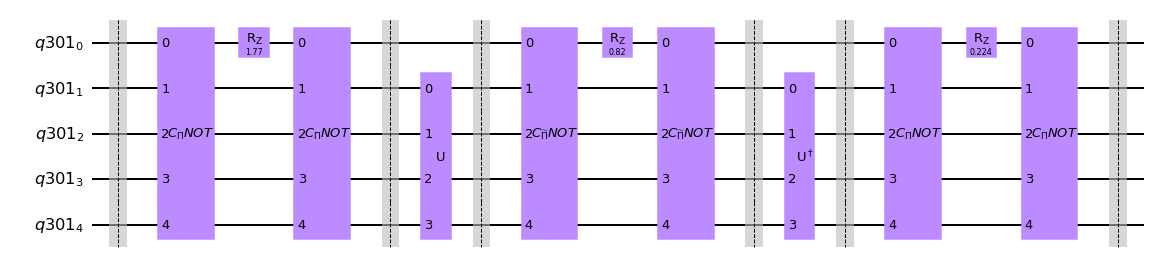

In [6]:
# create QSVT circuit, just for visualization purposes
q = 4
U = np.eye(2**q)
v = np.zeros(2**q) ; v[0] = 1
P = np.outer(v,v.conj())
phi = np.random.rand(3)
qsvt_circuit = create_qsvt_circuit(U,P,P, phi, q)
# draw the circuit
qsvt_circuit.draw(output = 'mpl')

### Polynomial approximation

We show some approximations of the sign function using polynomials of different degrees. We can see that the approximation gets better as the degree of the polynomial increases.

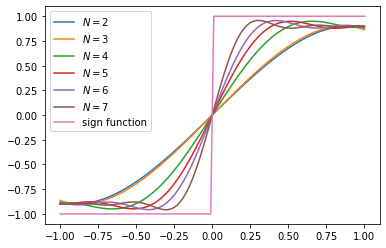

In [7]:
# check the polynomial approximation for different values of qubits 
N = np.arange(2,8)
for n in N:
    with io.capture_output() as captured:
        p = sign_approximating_polynomial(n)
    x = np.linspace(-1,1,100)
    plt.plot(x,p(x), label = r'$N = %d$'%n)

# plot the sign function
plt.plot(x,np.sign(x), label = 'sign function')
plt.legend()



## Grover - Numerical experiment

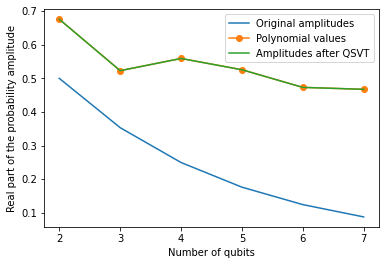

In [169]:
np.random.seed(42)

num_qubits = np.arange(2,8) # number of qubits

original_amplitudes = [1/np.sqrt(2**qubits) for qubits in num_qubits] # probability amplitudes, before QSVT

with io.capture_output() as captured: # suppress the output of pyqsp
    values_poly = [sign_approximating_polynomial(qubits)(2**(-0.5*qubits)) for qubits in num_qubits] # values of the approximating polynomial

amplitudes = np.zeros(num_qubits.size) # probability amplitudes, after QSVT
for i,qubits in enumerate(num_qubits):
    
    # U is the unitary operator which we block encode. It is just the Hadamard gate applied to all qubits
    H = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
    U = reduce(np.kron, [H]*qubits)

    # define the right projector
    all_zero_state = np.zeros(2**qubits) ; all_zero_state[0] = 1
    PR = np.outer(all_zero_state,all_zero_state.conj())

    # define the left projector - we choose it randomly. In a real application, we would have indirect access to it, through the oracle
    r = np.random.randint(0,2**qubits)
    m = np.zeros(2**qubits) ; m[r] = 1
    PL = np.outer(m,m.conj())

    # Estimate the phases, suppressing the output of pyqsp
    with io.capture_output() as captured:
        p = sign_approximating_polynomial(qubits)
        phi = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p.coef, signal_operator='Wx')

    # convert the phases from W-convention to R-convention
    phi = angles_from_W_to_R(phi)

    # create the QSVT circuit
    backend = Aer.get_backend('statevector_simulator')
    qsvt_circuit = create_qsvt_circuit(U,PL,PR, phi, qubits)

    # run the circuit and get the output statevector
    job = backend.run(qsvt_circuit)
    result = job.result()
    output_state = np.array(result.get_statevector(qsvt_circuit))

    # find the probability of measuring the |m> state
    amplitudes[i] =  output_state[2*r].real



# plot the results
plt.plot(num_qubits,original_amplitudes, label = 'Original amplitudes ')
plt.plot(num_qubits,values_poly, label = 'Polynomial values', marker = 'o')
plt.plot(num_qubits,amplitudes, label = 'Amplitudes after QSVT')
plt.xlabel('Number of qubits')
plt.ylabel('Real part of the probability amplitude')
plt.legend()



## Solving Linear Systems of Equations

### Utility Functions

In [170]:
def block_encode(A):
    """Block-encodes a matrix A into a unitary U.
    Args:
        A: The matrix to block-encode. We assume that the operator norm of A is <= 1.
    Returns:
        A unitary U such that U|0> = |A>.
    """
    n,m = A.shape

    A = pad_matrix(A)
    n,m = A.shape

    block_encoding = np.empty((n+m,n+m), dtype=complex)
    # upper left block
    block_encoding[:n,:m] = A
    # lower right block
    block_encoding[n:,m:] = -A.conj().T
    
    # do an SVD to get the other two blocks
    U,s,V = np.linalg.svd(A, full_matrices=True)

    # assert that the singular values are <= 1
    assert np.all(s <= 1), "The operator norm of A is larger than 1."
    

    # pad the singular values with zeros, depending on the size of A
    if n >= m:
        s1 = np.concatenate((s, np.zeros(n-m)))
        s2 = s 
    else:
        s1 = s
        s2 = np.concatenate((s, np.zeros(m-n)))
     
    # upper block
    upper_right_block = U @ np.diag(np.sqrt(1-s1**2)) @ U.conj().T
    block_encoding[:n,m:] = upper_right_block

    # lower left block
    lower_left_block = V.conj().T @ np.diag(np.sqrt(1-s2**2)) @ V
    block_encoding[n:,:m] = lower_left_block

    # padding with zeros to be a power of 2
    return block_encoding
    
# This was the first attempt for padding, but it is not a good idea     
""" 
def pad_matrix(A): 
    Returns a matrix that pads A with zeros to be a power of 2.
    Args:
        A: The matrix to pad.
    Returns:
        A matrix with zeros padded to A.
    n,m = A.shape
    N = int(2**np.ceil(np.log2(max(n,m))))
    padded_matrix = np.zeros((N,N), dtype=complex)
    padded_matrix[:n,:m] = A

    # the matrix C on the lower right corner, should be such that C@C_{dagger} = I
    C = np.zeros((N-n,N-m), dtype=complex)
    if n>m:
        C[:,:n-m] = np.eye(n-m)
    elif n<m:
        C[:m-n,:] = np.eye(m-n)
    else:
        C = np.eye(N-n)
    padded_matrix[n:,m:] = C
    return padded_matrix
 """

def pad_matrix(A):
    """Returns a matrix that pads A with zeros to be a power of 2.
    Args:
        A: The matrix to pad.
    Returns:
        A matrix with zeros padded to A.
    """
    n,m = A.shape
    N = int(2**np.ceil(np.log2(max(n,m))))
    padded_matrix = np.zeros((N,N), dtype=complex)
    padded_matrix[:n,:m] = A
    return padded_matrix


def xinverse_approximating_polynomial(kappa, epsilon):
    """Polynomal approxiamtion to 1/(2*kappa*x)"""
    
    target_function = pyqsp.poly.PolyOneOverX()
    coeffs, scale = target_function.generate(kappa=kappa, epsilon=epsilon, return_scale=True)
    
    # For some reason, pyqsp returns 1/x*scale with some `scale`
    # that might be different from 1/kappa. 
    # We remove this scale from our polynomial.
    
    return np.polynomial.Polynomial(coeffs/(scale*2*kappa))

def random_A(kappa, num_qubits, seed, square = True, real = True):
    """Construnct a random real operator A with ||A||<1 and condition number <= kappa.
        Size of A is n by m, which a both smaller than 2**num_qubits."""

    N = 2**num_qubits

    np.random.seed(seed) # set the seed of the random number generator
    n = np.random.randint(N//2+1, N+1) # for example if num_quibts = 2, then it is either 3 or 4
    
    if square:
        m = n 
    else:
        m = np.random.randint(N//2, N)
    
    if real: 
        V = scipy.stats.ortho_group.rvs(n, random_state=seed**2)
        W = scipy.stats.ortho_group.rvs(m, random_state=seed**3)
    else:
        V = scipy.stats.unitary_group.rvs(n, random_state=seed**2)
        W = scipy.stats.unitary_group.rvs(m, random_state=seed**3)

    singular_values = np.random.uniform(low=1/kappa, high=1, size=min(n, m)) 
    Sigma = np.zeros((n, m), dtype=complex)
    Sigma[:min(n, m), :min(n, m)] = np.diag(singular_values)

    A = V @ Sigma @ W.conj().T
    
    
    return A

def check_block_encoding(A, U):
    """Checks if a matrix A is unitary.
    Args:
        A: The matrix to check.
    Returns:
        True if A is unitary, False otherwise.
    """
    n,m = A.shape
        
    is_unitary = np.allclose(np.eye(len(U)), U@U.conj().T)
    is_block_encoding = np.allclose(U[:n,:m], A)

    return is_unitary and is_block_encoding

Check if the block encoding works

In [166]:
# create a random matrix A and block encode it
A = random_A(kappa = 1.1, num_qubits = 2, seed = 3, square = True)
U = block_encode(A)

print('A is ', A)
print('U is ', U[:4,:4])




A is  [[-0.06764353+0.j -0.92882648+0.j -0.31288814+0.j]
 [-0.61842949+0.j -0.15234671+0.j  0.66780068+0.j]
 [-0.67314639+0.j  0.23540944+0.j -0.57493672+0.j]]
U is  [[-0.06764353+0.j -0.92882648+0.j -0.31288814+0.j  0.        +0.j]
 [-0.61842949+0.j -0.15234671+0.j  0.66780068+0.j  0.        +0.j]
 [-0.67314639+0.j  0.23540944+0.j -0.57493672+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]]


In [176]:
num_qubits = 2 # we will use 2 qubits to encode the matrix A, so the matrix will be either 3x3 or 4x4 
A = random_A(kappa = kappa, num_qubits = num_qubits, seed = 3, square = False)
print(A)


[[-0.17041521+0.j -0.72551714+0.j]
 [-0.18362896+0.j  0.20876878+0.j]
 [-0.86017246+0.j  0.15942781+0.j]]


## Numerical Example

In [181]:
# create a random matrix A and block encode it
kappa = 1.5; epsilon = 0.1


num_qubits = 2 # we will use 2 qubits to encode the matrix A, so the matrix will be either 3x3 or 4x4 
A = random_A(kappa = kappa, num_qubits = num_qubits, seed = 2, square = False)
U = block_encode(A)
n = U.shape[0]//2 # the size of the matrix A

# check that U is unitary 
if check_block_encoding(A,U): 
    print('The block encoding is successful.')
else:
    print('The block encoding is not successful.')

# define the projector 
P = np.diag(np.concatenate((np.ones(n), np.zeros(n))))

with io.capture_output() as captured: # suppress the output of pyqsp
    p = xinverse_approximating_polynomial(kappa, epsilon)
    phi = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p.coef, signal_operator='Wx')
    phi = angles_from_W_to_R(phi)

# create the QSVT circuit
#backend = Aer.get_backend('statevector_simulator')
backend = Aer.get_backend('unitary_simulator')
qsvt_circuit = create_qsvt_circuit(U,P,P, phi, num_qubits+1) # one more qubit, since we block encode
job = backend.run(qsvt_circuit)
result = job.result()
circuit_matrix = np.array(result.get_unitary(qsvt_circuit))
circuit_matrix = circuit_matrix[::2,::2] # throwing the ancilla qubit, which is in the |0> state

# find the inverse of A
Ainv_qsvt = 2*kappa * np.real(circuit_matrix.conj().T[:n,:n])
# solve numerically the linear system Ax = b
Ainv = np.linalg.pinv(A)

# print both matrices and compare them
print('A inverse from QSVT:')
print(Ainv_qsvt)
print('A inverse from numpy:')
print(Ainv.real)

# calculate the 2-norm of the difference between the two matrices
#print('The 2-norm of the difference between the two matrices is:', np.linalg.norm(Ainv_qsvt-Ainv.real))








The block encoding is successful.
A inverse from QSVT:
[[ 1.06265543  0.53542416  0.25677656  0.        ]
 [ 0.48170898 -0.5299358  -1.03079266  0.        ]
 [ 0.24477306 -1.01360181  0.91164732  0.        ]
 [ 0.          0.          0.          0.        ]]
A inverse from numpy:
[[ 1.06393749  0.53729829  0.25602164]
 [ 0.48247242 -0.52242245 -1.04805092]
 [ 0.24325869 -1.02910173  0.94137842]]


# Tutorial code, debugging 

In [141]:
def projector_rotation(P, phi):
    """Computes exponential of a projector using relation e^{i (2P-1) x}= cos(x)+i(2P-1)sin(x)"""
    N = len(P)
    return np.eye(N)*np.cos(phi)+1j*(2*P-np.eye(N))*np.sin(phi)


def apply_QSVT(U, PL, PR, phis):
    
    phi_last = phis[-1]
    
    if len(phis) % 2 == 1: # Even polynomial
        phis_paired = phis[:-1]
        phi_0 = None
    else: # Odd polynomial
        phis_paired = phis[1:-1]
        phi_0 = phis[0]
    
    res = projector_rotation(PR, phi_last)
    
    for phi_R, phi_L in np.array(phis_paired).reshape(-1, 2)[::-1]:
        res =  projector_rotation(PR, phi_R) @ U.conj().T @  projector_rotation(PL, phi_L) @ U @ res
    
    if phi_0 is not None:
        res = projector_rotation(PL, phi_0) @ U @ res
        
    return res

class BlockEncoding:
    
    def __init__(self, M):
        
        self.num_rows = M.shape[0]
        self.num_cols = M.shape[1]
        self.dim = 2*self.block_dimension(max(self.num_cols, self.num_rows))
        
        self.diagonal_block = self.pad_matrix(M, self.dim//2)
        
        U, S, WH = np.linalg.svd(self.diagonal_block)
        
        self.U = U
        self.S = S
        self.WH = WH
        
        self.off_diagonal_block = self.make_off_diagonal_block(self.U, self.S, self.WH)
        
        self.unitary = self.unitary_from_blocks(
            self.diagonal_block, 
            self.off_diagonal_block)
        
        self.projector = np.kron(np.diag([1, 0]), np.eye(self.dim//2))
 
    @staticmethod
    def block_dimension(n):
        """Finds the minimum number of qubits to block encode a square matrix of dimension n"""
        return int(2**np.ceil(np.log2(n)))
        
    @staticmethod
    def pad_matrix(M, dim):
        """Pads a matrix with zeros make to make it into a d x d matrix.."""
        
        S = np.zeros((dim, dim), dtype=np.complex64)
        n_rows, n_cols = M.shape
        S[:n_rows,:n_cols] = M
        return S
    
    @staticmethod
    def make_off_diagonal_block(u, s, wh):
        assert np.all(s<=1), f'All singular values {s} must be less than 1.'
        return u @ np.diag(np.sqrt(1-s**2)) @ wh
    
    @staticmethod
    def unitary_from_blocks(A, B):
        n = A.shape[0]
        U = np.zeros((2*n, 2*n), dtype=np.complex64)
        U[:n, :n] = A
        U[:n,n:2*n] = B
        U[n:2*n, :n] = B
        U[n:2*n, n:2*n] = -A
        
        assert np.allclose(U @ U.conj().T, np.eye(2*n), atol=1e-5), 'Ops, block encoding is not unitary.'
        return U

seed = 42
np.random.seed(seed)

num_qubits = 2
N = 2**num_qubits

epsilon = 0.1
kappa = 3.5 ; 

# We will keep track of accuracies and polynomial degrees.


# Generate a random linear system.
A = random_A(kappa, num_qubits, seed, square=True, real=True)
n, m = A.shape

# Block encode it.
block_encoding = BlockEncoding(A)
U = block_encoding.unitary
P = block_encoding.projector

# Determine approximating polynomial and QSP angles.
p = xinverse_approximating_polynomial(kappa, epsilon)
degree = p.degree()

phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p.coef, signal_operator='Wx')
phis = angles_from_W_to_R(phis)

# The QSVT circuit itself.
U_phi = apply_QSVT(U, P, P, phis)

# Compare with the exact pseudo-inverse via the operator norm.
exact_pseudo_inverse = np.linalg.pinv(A)
our_pseudo_inverse = 2*kappa*np.real(U_phi.conj().T)[:m, :n] 

error = np.linalg.norm(our_pseudo_inverse-exact_pseudo_inverse, ord=2)




b=43, j0=17
[PolyOneOverX] minimum [-4.21564427] is at [-0.17130997]: normalizing
[PolyOneOverX] bounding to 0.5
[pyqsp.PolyOneOverX] pcoefs=[ 0.00000000e+00  5.09933532e+00  0.00000000e+00 -1.06927238e+02
  0.00000000e+00  1.45098852e+03  0.00000000e+00 -1.41930470e+04
  0.00000000e+00  1.05146426e+05  0.00000000e+00 -6.03553206e+05
  0.00000000e+00  2.71140803e+06  0.00000000e+00 -9.57229822e+06
  0.00000000e+00  2.65857022e+07  0.00000000e+00 -5.80172437e+07
  0.00000000e+00  9.90929511e+07  0.00000000e+00 -1.31461765e+08
  0.00000000e+00  1.33721457e+08  0.00000000e+00 -1.02119224e+08
  0.00000000e+00  5.65768857e+07  0.00000000e+00 -2.14474002e+07
  0.00000000e+00  4.97210835e+06  0.00000000e+00 -5.31330778e+05]


## Literature
[1] J. M. Martyn, Z. M. Rossi, A. K. Tan, and I. L. Chuang, A Grand Unification of Quantum Algorithms, PRX Quantum 2, (2021).

[2] A. Gilyén, Y. Su, G. H. Low, and N. Wiebe, Quantum singular value transformation and beyond: Exponential improvements for quantum matrix arithmetics, Proceedings of the Annual ACM Symposium on Theory of Computing 193 (2019).

[3] A. Gilyén, Quantum Singular Value Transformation& Its Algorithmic Applications, (2019).

[4] I. Chuang and et al, Pyqsp: Quantum Signal Processing, (2022).

[5] Introduction to Quantum Singular Value Transformation, https://idnm.github.io/blog/posts/quantum_singular_value_transformation_intro/
